<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/07_question-answering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="ÏΩîÎû©ÏóêÏÑú Ïã§ÌñâÌïòÍ∏∞"/></a>
</td></tr></table>

**_Ïù¥ ÎÖ∏Ìä∏Î∂ÅÏùÄ haystack 1.4.0ÏùÑ ÏÇ¨Ïö©ÌïòÎäî Î≤ÑÏ†ÑÏûÖÎãàÎã§._**

In [1]:
# ÏΩîÎû©ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎ©¥ Îã§Ïùå ÏΩîÎìúÎ•º Ï£ºÏÑù Ï≤òÎ¶¨ÌïòÏÑ∏Ïöî.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7.2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 566 (delta 181), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (566/566), 48.97 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (280/280), done.
/content/nlp-with-transformers
‚è≥ Installing base requirements ...
‚úÖ Base requirements installed!
Using transformers v4.13.0
Using datasets v2.10.1


INFO:haystack.modeling.model.optimization:apex not found, won't use it. See https://nvidia.github.io/apex/
ERROR:root:Failed to import 'magic' (from 'python-magic' and 'python-magic-bin' on Windows). FileTypeClassifier will not perform mimetype detection on extensionless files. Please make sure the necessary OS libraries are installed if you need this functionality.


Using haystack v1.4.0


In [2]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [3]:
# haystackÏùò Î°úÍπÖÏùÑ ÎÅïÎãàÎã§.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# ÏßàÎ¨∏ ÎãµÎ≥Ä

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_marie-curie.png?raw=1" id="marie-curie"/>

## Î¶¨Î∑∞ Í∏∞Î∞ò QA ÏãúÏä§ÌÖú Íµ¨Ï∂ïÌïòÍ∏∞

### Îç∞Ïù¥ÌÑ∞ÏÖã

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_phone.png?raw=1" id="phone"/>

In [4]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [5]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [7]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}Ïóê ÏûàÎäî ÏßàÎ¨∏ Í∞úÏàò: {df['id'].nunique()}")

trainÏóê ÏûàÎäî ÏßàÎ¨∏ Í∞úÏàò: 1295
testÏóê ÏûàÎäî ÏßàÎ¨∏ Í∞úÏàò: 358
validationÏóê ÏûàÎäî ÏßàÎ¨∏ Í∞úÏàò: 255


In [8]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

title                        question                answers.text  \
791   B005DKZTMG  Does the keyboard lightweight?  [this keyboard is compact]   
1159  B00AAIPT76             How is the battery?                          []   

     answers.answer_start  \
791                 [215]   
1159                   []   

                                                                              context  
791   I really like this keyboard.  I give it 4 stars because it doesn't have a CA...  
1159  I bought this after the first spare gopro battery I bought wouldn't hold a c...

In [9]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

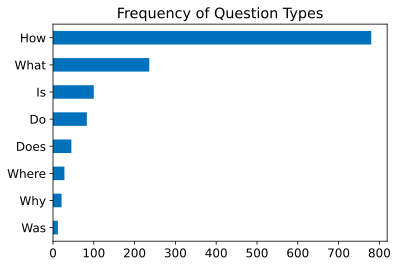

In [10]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [11]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### ÏÇ¨Ïù¥ÎìúÎ∞î: Ïä§ÌÉ†Ìè¨Îìú ÏßàÎ¨∏ ÎãµÎ≥Ä Îç∞Ïù¥ÌÑ∞ÏÖã

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-sota.png?raw=1" id="squad-sota"/>

### ÏÇ¨Ïù¥ÎìúÎ∞î ÎÅù

### ÌÖçÏä§Ìä∏ÏóêÏÑú Îãµ Ï∂îÏ∂úÌïòÍ∏∞

#### Î≤îÏúÑ Î∂ÑÎ•ò

<img alt="QA Head" caption="The span classification head for QA tasks" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-head.png?raw=1" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-models.png?raw=1" id="squad-models"/> 

#### QAÎ•º ÏúÑÌïú ÌÖçÏä§Ìä∏ ÌÜ†ÌÅ∞Ìôî

In [12]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [14]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

0     1     2     3     4     5     6     7    8     9   ...  \
input_ids       101  2129  2172  2189  2064  2023  2907  1029  102  2019  ...   
token_type_ids    0     0     0     0     0     0     0     0    0     1  ...   
attention_mask    1     1     1     1     1     1     1     1    1     1  ...   

                  18    19     20    21    22    23    24    25    26   27  
input_ids       2061  2055  25961  2847  5834  2006  5371  2946  1012  102  
token_type_ids     1     1      1     1     1     1     1     1     1    1  
attention_mask     1     1      1     1     1     1     1     1     1    1  

[3 rows x 28 columns]

In [15]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [16]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [17]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [18]:
print(f"ÏûÖÎ†• ID ÌÅ¨Í∏∞: {inputs.input_ids.size()}")
print(f"ÏãúÏûë Î°úÏßì ÌÅ¨Í∏∞: {start_logits.size()}")
print(f"Ï¢ÖÎ£å Î°úÏßì ÌÅ¨Í∏∞: {end_logits.size()}")

ÏûÖÎ†• ID ÌÅ¨Í∏∞: torch.Size([1, 28])
ÏãúÏûë Î°úÏßì ÌÅ¨Í∏∞: torch.Size([1, 28])
Ï¢ÖÎ£å Î°úÏßì ÌÅ¨Í∏∞: torch.Size([1, 28])


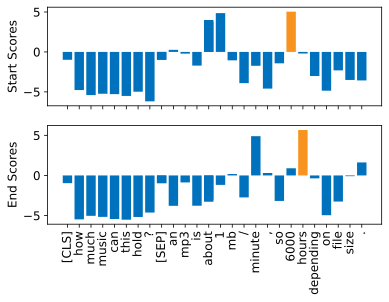

In [19]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê ÎåÄÌïú ÏòàÏ∏° Î°úÏßì. Ïò§Î†åÏßÄ ÏÉâ ÌÜ†ÌÅ∞Ïù¥ Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÎ•º Í∞ÄÏßÑ ÌÜ†ÌÅ∞ÏûÖÎãàÎã§.
# Ïù¥ Í∑∏ÎûòÌîÑÎäî Îã§ÏùåÏùÑ Ï∞∏Í≥†ÌñàÏäµÎãàÎã§. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [20]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"ÏßàÎ¨∏: {question}")
print(f"ÎãµÎ≥Ä: {answer}")

ÏßàÎ¨∏: How much music can this hold?
ÎãµÎ≥Ä: 6000 hours


In [21]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.26516157388687134,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.220829576253891,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.102535180747509, 'start': 16, 'end': 27, 'answer': '1 MB/minute'}]

In [22]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068412780761719, 'start': 0, 'end': 0, 'answer': ''}

#### Í∏¥ ÌÖçÏä§Ìä∏ Îã§Î£®Í∏∞

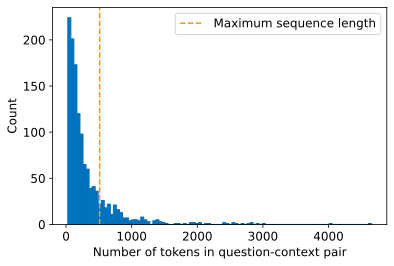

In [23]:
# SubjQA ÌõàÎ†® ÏÑ∏Ìä∏Ïóê ÏûàÎäî ÏßàÎ¨∏-Î¨∏Îß• ÏåçÏùò ÌÜ†ÌÅ∞ Î∂ÑÌè¨
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents‚Äîthe first bar corresponds to the question, while the second bar is the context captured in each window" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_sliding-window.png?raw=1" id="sliding-window"/>

In [24]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [25]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} ÏúàÎèÑÏóêÎäî {len(window)}Í∞úÏùò ÌÜ†ÌÅ∞Ïù¥ ÏûàÏäµÎãàÎã§.")

#0 ÏúàÎèÑÏóêÎäî 100Í∞úÏùò ÌÜ†ÌÅ∞Ïù¥ ÏûàÏäµÎãàÎã§.
#1 ÏúàÎèÑÏóêÎäî 88Í∞úÏùò ÌÜ†ÌÅ∞Ïù¥ ÏûàÏäµÎãàÎã§.


In [26]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### Ìó§Ïù¥Ïä§ÌÉùÏùÑ ÏÇ¨Ïö©Ìï¥ QA ÌååÏù¥ÌîÑÎùºÏù∏ Íµ¨Ï∂ïÌïòÍ∏∞

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_retriever-reader.png?raw=1" id="retriever-reader"/>

#### Î¨∏ÏÑú Ï†ÄÏû•ÏÜå Ï¥àÍ∏∞ÌôîÌïòÍ∏∞

In [27]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [28]:
import os
from subprocess import Popen, PIPE, STDOUT

# Î∞±Í∑∏ÎùºÏö¥Îìú ÌîÑÎ°úÏÑ∏Ïä§Î°ú ÏùºÎûòÏä§Ìã±ÏÑúÏπòÎ•º Ïã§ÌñâÌï©ÎãàÎã§
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# ÏùºÎûòÏä§Ìã±ÏÑúÏπòÍ∞Ä ÏãúÏûëÌï† ÎïåÍπåÏßÄ Í∏∞Îã§Î¶ΩÎãàÎã§
!sleep 30

In [29]:
# ÎòêÎäî ÎèÑÏª§Í∞Ä ÏÑ§ÏπòÎêòÏñ¥ ÏûàÎã§Î©¥
from haystack.utils import launch_es

launch_es()

In [30]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "da1b9e54cdbe",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "WEEtA5s6Rt6n7zJXL4zp0w",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [31]:
# document_store --> document_stores
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# Î∞ÄÏßë Î¶¨Ìä∏Î¶¨Î≤ÑÏóêÏÑú ÏÇ¨Ïö©Ìï† Î¨∏ÏÑú ÏûÑÎ≤†Îî©ÏùÑ Î∞òÌôòÌï©ÎãàÎã§.
document_store = ElasticsearchDocumentStore(return_embedding=True)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://haystack.deepset.ai/guides/telemetry


In [32]:
# ÎÖ∏Ìä∏Î∂ÅÏùÑ Îã§Ïãú ÏãúÏûëÌï† Îïå ÏùºÎûòÏä§Ìã±ÏÑúÏπò Ï†ÄÏû•ÏÜåÎ•º Î™®Îëê ÎπÑÏö∞Îäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [33]:
for split, df in dfs.items():
    # Ï§ëÎ≥µ Î¶¨Î∑∞Î•º Ï†úÏô∏ÏãúÌÇµÎãàÎã§
    docs = [{"content": row["context"], "id": row["review_id"],
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(documents=docs, index="document")
    
print(f"{document_store.get_document_count()}Í∞ú Î¨∏ÏÑúÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§")

1615Í∞ú Î¨∏ÏÑúÍ∞Ä Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§


#### Î¶¨Ìä∏Î¶¨Î≤Ñ Ï¥àÍ∏∞ÌôîÌïòÍ∏∞

Ìó§Ïù¥Ïä§ÌÉù 1.4ÏóêÏÑú `ElasticsearchRetriever`Í∞Ä `BM25Retriever`Î°ú Î∞îÎÄåÏóàÏäµÎãàÎã§. Ïó¨Ï†ÑÌûà Î≤ÑÏ†Ñ 1.5ÏóêÏÑú `ElasticsearchRetriever`Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏßÄÎßå Ìñ•ÌõÑ Î≤ÑÏ†ÑÏóêÏÑú ÏÇ≠Ï†úÎê† Ïàò ÏûàÏäµÎãàÎã§.

In [34]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

In [35]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [36]:
print(retrieved_docs[0])

<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to
myself.  I have been a kindle user for 4 years and this is my third one.  I
never  ...'>


#### Î¶¨Îçî Ï¥àÍ∏∞ÌôîÌïòÍ∏∞

In [37]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find deepset/minilm-uncased-squad2 locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...
INFO:haystack.modeling.model.language_model:Loaded deepset/minilm-uncased-squad2
INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [38]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.64809501171112,
'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score':
0.5293066054582596, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}],
'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id':
'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


#### Î™®Îëê Ìï©ÏπòÍ∏∞

In [39]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [40]:
n_answers = 3
preds = pipe.run(query=query, 
                 params={"Retriever": {"top_k": 3, "filters": {"item_id": [item_id], "split": ["train"]}}, 
                                      "Reader": {"top_k": n_answers}})

print(f"ÏßàÎ¨∏: {preds['query']} \n")
for idx in range(n_answers):
    print(f"ÎãµÎ≥Ä {idx+1}: {preds['answers'][idx].answer}")
    print(f"Ìï¥Îãπ Î¶¨Î∑∞ ÌÖçÏä§Ìä∏: ...{preds['answers'][idx].context}...")
    print("\n\n")

ÏßàÎ¨∏: Is it good for reading?

ÎãµÎ≥Ä 1: it is great for reading books when no light is available
Ìï¥Îãπ Î¶¨Î∑∞ ÌÖçÏä§Ìä∏: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...



ÎãµÎ≥Ä 2: I mainly use it for book reading
Ìï¥Îãπ Î¶¨Î∑∞ ÌÖçÏä§Ìä∏: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



ÎãµÎ≥Ä 3:
Ìï¥Îãπ Î¶¨Î∑∞ ÌÖçÏä§Ìä∏: ...None...





## QA ÌååÏù¥ÌîÑÎùºÏù∏ Í∞úÏÑ†ÌïòÍ∏∞

### Î¶¨Ìä∏Î¶¨Î≤Ñ ÌèâÍ∞ÄÌïòÍ∏∞

In [41]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [42]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
    # Î¶¨Ìä∏Î¶¨Î≤ÑÏóêÏÑú ÌïÑÌÑ∞ÎßÅÏùÑ ÏúÑÌï¥ ÏÇ¨Ïö©ÌïòÎäî Î©îÌÉÄÎç∞Ïù¥ÌÑ∞
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # ÎãµÏù¥ ÏûàÎäî ÏßàÎ¨∏ÏùÑ Î†àÏù¥Î∏îÏóê Ï∂îÍ∞ÄÌï©ÎãàÎã§
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                query=row["question"], answer=Answer(answer=answer), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False, filters={"item_id": [meta["item_id"]], "split":["test"]})
            labels.append(label)
    # ÎãµÏù¥ ÏóÜÎäî ÏßàÎ¨∏ÏùÑ Î†àÏù¥Î∏îÏóê Ï∂îÍ∞ÄÌï©ÎãàÎã§
    else:
        label = Label(
            query=row["question"], answer=Answer(answer=""), origin="gold-label", document=Document(content=row["context"], id=row["review_id"]),
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True, filters={"item_id": [row["title"]], "split":["test"]})
        labels.append(label)

In [43]:
print(labels[0])

<Label: {'id': '627f7fcf-3387-4832-8744-856da206d2e1', 'query': 'What is the
tonal balance of these headphones?', 'document': {'content': "I have been a
headphone fanatic for thirty years and have owned and used a variety of
headphones over those years, to include Stax SR-5, Sennheiser HD-424 and HD-580.
The Sony MDRV6 excells as the best value of any headphone that I've ever owned.
They are especially good at producing natural-sounding deep bass, and the
overall octave-to-octave balance is excellent.  The sound quality is all in all
comparable to other headphones that cost considerably more.The MDRV6 is
especially well-suited for travel due to the collapsible design, and for noisy
environments or for quiet environments such as a library where the sound emitted
by open-back headphones would distract others.The MDRV6 is not quite as
comfortable as some other headphones, but the comfort can be improved enormously
by replacing the pads with the velour pads from BeyerDynamic.  The pads tha

In [44]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}Í∞úÏùò \
ÏßàÎ¨∏ ÎãµÎ≥Ä ÏåçÏùÑ Î°úÎìúÌñàÏäµÎãàÎã§.""")

455Í∞úÏùò ÏßàÎ¨∏ ÎãµÎ≥Ä ÏåçÏùÑ Î°úÎìúÌñàÏäµÎãàÎã§.


In [45]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [46]:
# Îã§ÏùåÏ≤òÎüº ÏõêÌïòÎäî top_k Í∞íÏúºÎ°ú ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ Ïã§ÌñâÌï† Ïàò ÏûàÏäµÎãàÎã§
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

In [47]:
print(f"Ïû¨ÌòÑÏú®@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Ïû¨ÌòÑÏú®@3: 0.96


In [48]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"][["query", "filters", "rank", "content", "gold_document_contents", "document_id", "gold_document_ids", "gold_id_match"]]

query  \
0  How do you like the lens?   
1  How do you like the lens?   
0  How do you like the lens?   
1  How do you like the lens?   
2  How do you like the lens?   
0  How do you like the lens?   

                                             filters  rank  \
0  b'{"item_id": ["B00006I53S"], "split": ["test"]}'   1.0   
1  b'{"item_id": ["B00006I53S"], "split": ["test"]}'   2.0   
0  b'{"item_id": ["B00007E7JU"], "split": ["test"]}'   1.0   
1  b'{"item_id": ["B00007E7JU"], "split": ["test"]}'   2.0   
2  b'{"item_id": ["B00007E7JU"], "split": ["test"]}'   3.0   
0  b'{"item_id": ["B0025EWXEU"], "split": ["test"]}'   1.0   

                                                                           content  \
0  I bought this lens for my Canon 20D digital camera and have found it to be a...   
1  I am not a professional or expert photographer...so take these comments with...   
0  I think that the title says it all. It is one of the cheapest lens on the ma...   
1  I bough this lens for a relative who bought my old canon rebel xti from me (...   
2  I fell in love with the lens the moment I started using it. sure, the build ...   
0  I have read a lot of negative press about this lens, but I have to tell you ...   

                                                            gold_document_contents  \
0  [I bought this lens for my Canon 20D digital camera and have found it to be ...   
1  [I bought this lens for my Canon 20D digital camera and have found it to be ...   
0                                                                               []   
1                                                                               []   
2                                                                               []   
0  [I have read a lot of negative press about this lens, but I have to tell you...   

                        document_id  \
0  fac2e8bec06035a70307dd1e8034ea63   
1  26bf35fe7f9a73d28535d5072ab17714   
0  9cae133919a2dc476c371cde9e5effb8   
1  a1f6e39766a79f1475b3dbe07e517e04   
2  0fc71a2e4ec350e845ed384717792ad8   
0  47f76b8f62cf296d394d993741d660aa   

                                                      gold_document_ids  \
0                                    [fac2e8bec06035a70307dd1e8034ea63]   
1                                    [fac2e8bec06035a70307dd1e8034ea63]   
0                                                                    []   
1                                                                    []   
2                                                                    []   
0  [47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]   

   gold_id_match  
0            1.0  
1            0.0  
0            0.0  
1            0.0  
2            0.0  
0            1.0

In [49]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}
    # ÏµúÎåÄ top_kÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§
    max_top_k = max(topk_values)
    # ÌååÏù¥ÌîÑÎùºÏù∏ÏùÑ ÎßåÎì≠ÎãàÎã§
    p = DocumentSearchPipeline(retriever=retriever)
    # ÌÖåÏä§Ìä∏ ÏÑ∏Ìä∏Ïóê ÏûàÎäî ÏßàÎ¨∏-ÎãµÎ≥Ä ÏåçÏùÑ ÏàúÌöåÌïòÎ©¥ÏÑú ÏµúÎåÄ top_kÎ°ú Ï∂îÎ°†ÏùÑ Ïã§ÌñâÌï©ÎãàÎã§
    eval_result = p.eval(
        labels=labels_agg,
        params={"Retriever": {"top_k": max_top_k}},
    )
    # Í∞Å top_k Í∞íÏóê ÎåÄÌï¥ Ïû¨ÌòÑÏú®ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§
    for topk in topk_values:
        metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
        topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


bm25_topk_df = evaluate_retriever(bm25_retriever)

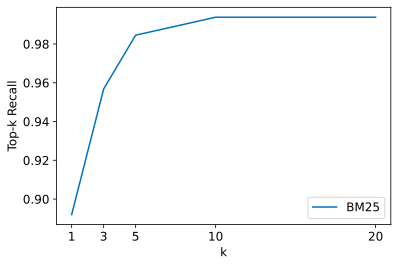

In [50]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([bm25_topk_df], ["BM25"])

#### DPR

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_dpr.png?raw=1" id="dpr"/>

In [51]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/493 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-question_encoder-single-nq-base


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded facebook/dpr-ctx_encoder-single-nq-base


In [52]:
document_store.update_embeddings(retriever=dpr_retriever)

INFO:haystack.document_stores.elasticsearch:Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

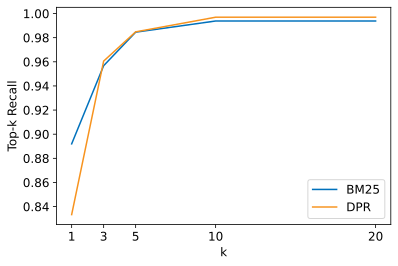

In [53]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Î¶¨Îçî ÌèâÍ∞ÄÌïòÍ∏∞

In [54]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [55]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [56]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ['exact_match', 'f1']
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])

    eval_result = p.eval(
        labels=labels_agg,
        documents= [[label.document for label in multilabel.labels] for multilabel in labels_agg],
        params={},
    )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
                
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

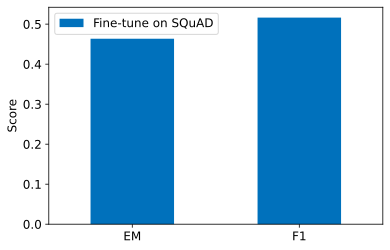

In [57]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### ÎèÑÎ©îÏù∏ Ï†ÅÏùë

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_squad-schema.png?raw=1" id="squad-schema"/>

In [58]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # ÌäπÏ†ï Î¨∏Îß•ÏúºÎ°ú Ï†ÑÏ≤¥ ÏßàÎ¨∏-Îãµ ÏåçÏùÑ ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # qas Î∞∞Ïó¥ÏùÑ ÎßåÎì≠ÎãàÎã§
        for qid, question in id2question.items():
            # ÌïòÎÇòÏùò ÏßàÎ¨∏ IDÏóê ÎåÄÌï¥ ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # ÎãµÎ≥Ä Í∞ÄÎä•Ìïú ÏßàÎ¨∏ÏùÑ Ï∂îÍ∞ÄÌï©ÎãàÎã§
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # ÏßàÎ¨∏-Îãµ ÏåçÏùÑ qasÏóê Ï∂îÍ∞ÄÌï©ÎãàÎã§
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Î¨∏Îß•Í≥º ÏßàÎ¨∏-Îãµ ÏåçÏùÑ paragraphsÏóê Ï∂îÍ∞ÄÌï©ÎãàÎã§
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [59]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [60]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Í∞Å Ï†úÌíà IDÏóê ÎåÄÌï¥ `paragraphs`Î•º ÎßåÎì≠ÎãàÎã§
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Í≤∞Í≥ºÎ•º ÎîîÏä§ÌÅ¨Ïóê Ï†ÄÏû•Ìï©ÎãàÎã§
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [61]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1265/1265 [00:00<00:00, 12599.31 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In compar

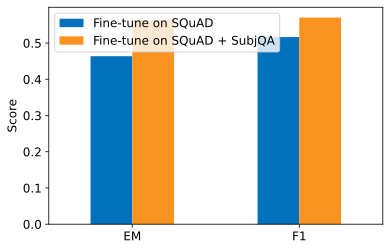

In [62]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [63]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.model.language_model:LOADING MODEL
INFO:haystack.modeling.model.language_model:=============
INFO:haystack.modeling.model.language_model:Could not find microsoft/MiniLM-L12-H384-uncased locally.
INFO:haystack.modeling.model.language_model:Looking on Transformers Model Hub (in local cache and online)...


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/127M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Loaded microsoft/MiniLM-L12-H384-uncased


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.infer:Got ya 2 parallel workers to do inference ...
INFO:haystack.modeling.infer: 0     0  
INFO:haystack.modeling.infer:/w\   /w\ 
INFO:haystack.modeling.infer:/'\   / \ 


In [64]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: electronics-train.json 
INFO:haystack.modeling.data_handler.data_silo:Multiprocessing disabled, using a single worker to convert 1265dictionaries to pytorch datasets.
Preprocessing Dataset electronics-train.json: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1265/1265 [00:00<00:00, 12178.22 Dicts/s]WARNING:haystack.modeling.data_handler.processor:Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In compar

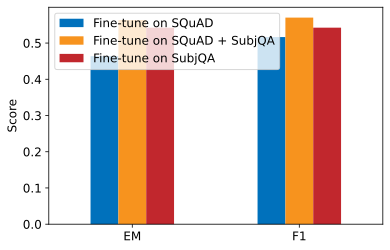

In [65]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### Ï†ÑÏ≤¥ QA ÌååÏù¥ÌîÑÎùºÏù∏ ÌèâÍ∞ÄÌïòÍ∏∞

In [66]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# ÌèâÍ∞ÄÌïòÍ∏∞!
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Î¶¨ÎçîÏóêÏÑú ÏßÄÌëúÎ•º Ï∂îÏ∂úÌï©ÎãàÎã§
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

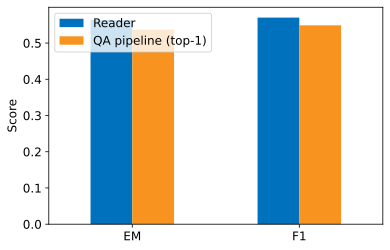

In [67]:
# Î¶¨ÎçîÏôÄ Ï†ÑÏ≤¥ QA ÌååÏù¥ÌîÑÎùºÏù∏Ïùò EMÍ≥º F1-Ï†êÏàò ÎπÑÍµê
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

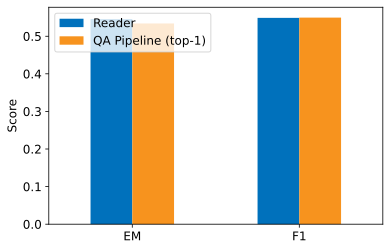

In [68]:
# ÎòêÎäî QA ÌååÏù¥ÌîÑÎùºÏù∏Í≥º Î¶¨Îçî ÏßÄÌëúÎ•º ÌïúÎ≤àÏóê ÏñªÏäµÎãàÎã§
# Î¶¨Îçî ÌèâÍ∞ÄÎäî ÏãúÎÆ¨Î†àÏù¥Ìä∏Îêú ÏôÑÎ≤ΩÌïú Î¶¨Ìä∏Î¶¨Î≤Ñ Í≤∞Í≥ºÎ•º ÏÇ¨Ïö©Ìï¥ Îëê Î≤àÏß∏Î°ú Ïã§ÌñâÎê©ÎãàÎã§
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# ÏãúÎÆ¨Î†àÏù¥Ìä∏Îêú ÏôÑÎ≤ΩÌïú Î¶¨Ìä∏Î¶¨Î≤ÑÎ°ú Í≤©Î¶¨ÎêòÏñ¥ Ïã§ÌñâÎêú Î¶¨ÎçîÎ°úÎ∂ÄÌÑ∞ ÏßÄÌëúÎ•º Ï∂îÏ∂úÌï©ÎãàÎã§
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

## Ï∂îÏ∂úÏ†Å QAÎ•º ÎÑòÏñ¥ÏÑú

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_rag-architecture.png?raw=1" id="rag"/>

In [69]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

INFO:haystack.modeling.utils:Using devices: CUDA
INFO:haystack.modeling.utils:Number of GPUs: 1


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

In [70]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [71]:
def generate_answers(query, top_k_generator=3): 
    preds = pipe.run(query=query, 
                     params={"Retriever": {"top_k":5, 
                                  "filters":{"item_id": ["B0074BW614"]}},
                             "Generator": {"top_k": top_k_generator}})  
    print(f"ÏßàÎ¨∏: {preds['query']} \n")
    for idx in range(top_k_generator):
        # print(f"ÎãµÎ≥Ä {idx+1}: {preds['answers'][idx]['answer']}")
        print(f"ÎãµÎ≥Ä {idx+1}: {preds['answers'][idx].answer}")

In [72]:
generate_answers(query)

/usr/local/lib/python3.8/dist-packages/transformers/models/rag/tokenization_rag.py:92: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of ü§ó Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation_utils.py:1747: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


ÏßàÎ¨∏: Is it good for reading?

ÎãµÎ≥Ä 1:  the screen is absolutely beautiful
ÎãµÎ≥Ä 2:  the Screen is absolutely beautiful
ÎãµÎ≥Ä 3:  Kindle fire


In [73]:
generate_answers("What is the main drawback?")

ÏßàÎ¨∏: What is the main drawback?

ÎãµÎ≥Ä 1:  the price
ÎãµÎ≥Ä 2:  no flash support
ÎãµÎ≥Ä 3:  the cost


## Í≤∞Î°†

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter07_qa-pyramid.png?raw=1" id="qa-pyramid"/> 